**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Training our first CNN for Multiclass Image Classification

## 1. Set up

#### 1.1 TensorFlow + Keras

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on: <br/>
https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ <br/>
https://www.tensorflow.org/api_docs/python/tf/random/set_seed

In [4]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(42)
set_seed(42)

#### 1.3 Other imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#### 1.4 CIFAR-10
https://keras.io/api/datasets/cifar10/ <br/>
https://en.wikipedia.org/wiki/CIFAR-10

In [6]:
from tensorflow.keras.datasets import cifar10

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

The dataset is already split into a training set and a test set.

In [8]:
# download done in folder: "~/.keras/datasets"
import os
os.listdir(os.path.expanduser('~/.keras/datasets'))

['fashion-mnist',
 'mnist.npz',
 'cifar-10-batches-py',
 'cifar-10-batches-py.tar.gz']

In [9]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')

print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)

X_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


In [10]:
# reshape labels
y_train = y_train.ravel()
y_test = y_test.ravel()

In [11]:
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

y_train.shape: (50000,)
y_test.shape: (10000,)


In [12]:
print(f'Number of Classes: {np.unique(y_train).shape[0]}')
print(f'Classes: {np.unique(y_train)}')

Number of Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


In [13]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [14]:
y_train.shape

(50000,)

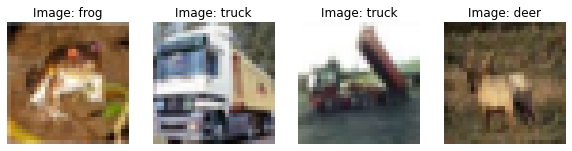

In [15]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, X_train, y_train):
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(f'Image: {class_names[label]}')

In [16]:
# 8-bit gray scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}')

Min. value of X_train: 0
Max. value of X_train: 255

Min. value of X_train: 0
Max. value of X_train: 255


#### 1.5 (Simple) Feature scaling
Since we are going to train the neural network using _Gradient Descent_, we must scale the **input features**. For simplicity, we’ll scale the pixel intensities down to the _0–1_ range by dividing them by **255.0** (8-bit gray image):

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
# rescaled 8-bit gray scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}')

Min. value of X_train: 0.0
Max. value of X_train: 1.0

Min. value of X_train: 0.0
Max. value of X_train: 1.0


## 2. Building and Training a MLP via Keras

### 2.1 Defining the Network Architecture
Proposed architecture for Multiclass Classification:
- INPUT [32x32x3]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- CONV [32, 4x4x3, 'valid']
- RELU => MAX_POOL [2x2, stride=(1,1)]
- FLATTEN
- FC [256]
- RELU => FC [10, 'softmax']

#### **Defining the Network's Architecture**

In [19]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)


In [20]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten


model = Sequential([
    Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

### Visualizing the Architecture

#### Native Keras Function: `plot_model`
https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

Requirements:
- `graphviz` software for graph visualization
  + `sudo apt-get install graphviz`
  + `pip install graphviz`
- `pip install pydot`

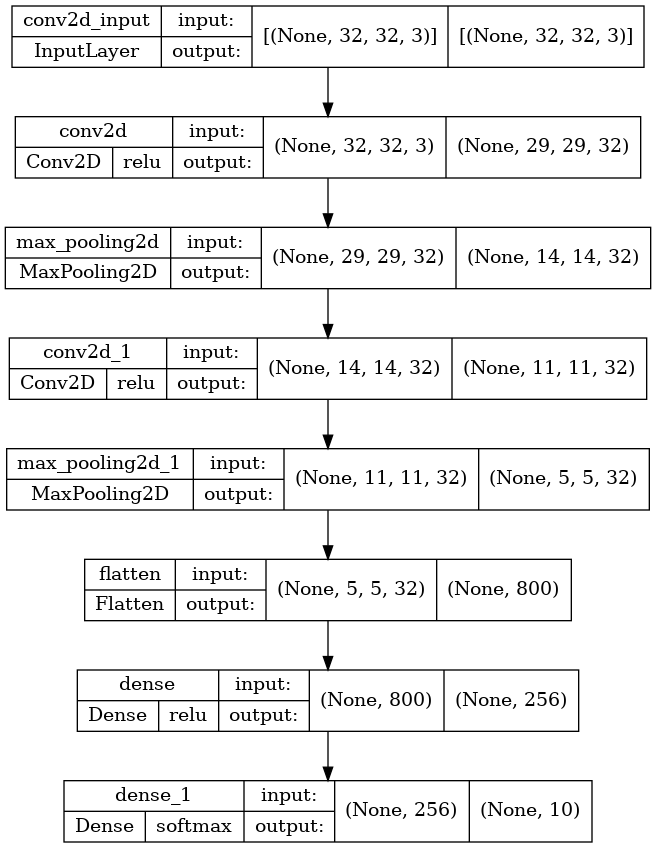

In [23]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

#### visualkeras
https://github.com/paulgavrikov/visualkeras <br/>
https://analyticsindiamag.com/how-to-visualize-deep-learning-models-using-visualkeras/#:~:text=Visualkeras%20is%20a%20python%20package,style%20architecture%20of%20neural%20networks.

More indicated for Deep Neural Networks, especially CNNs.

Requirements:
- `pip install visualkeras`

In [24]:
import visualkeras

In [25]:
visualkeras.layered_view(model, legend=True, scale_z=1).show() # display using your system viewer

### 2.2 Compiling: Defining the Loss Function, Optimizer, and Metrics

In [26]:
# Model compilation: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### 2.4 Training

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [28]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit

history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4186 - accuracy: 0.8558
Epoch 2/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3950 - accuracy: 0.8625
Epoch 3/30
 898/1563 [================>.............] - ETA: 1s - loss: 0.3585 - accuracy: 0.8775

KeyboardInterrupt: 

#### **Visualizing the training history**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df

In [ ]:
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epochs')
plt.ylabel('Score')

The _training set_ performance ends up beating the _validation performance_, as is generally the case when you train for long enough. <br/>
You can tell that the model _has not quite converged yet_, as the _validation loss_ is still (or could be) going down, so you should probably
**continue training**.

It’s as simple as calling the `fit()` method again, since Keras **_just_ continues training where it left off**.

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Note that our _training loss_ is lower than that from the last epoch in the previous training. This confirms that our `fit()` method **continues training** where it left off.

#### **More about training in Keras**
Extracted from "A. Géron, Hands-on Machine Learning (Chapter 10)".

If the training set was _very skewed_, with some classes being _overrepresented_ and others _underrepresented_, it would be useful to set the `class_weight` argument when calling the `fit()` method, which would give a **larger weight** to _underrepresented classes_ and a **lower weight** to _overrepresented classes_. These weights would be used by Keras when _computing the loss_.

If you need _per-instance weights_, set the `sample_weight` argument (if both `class_weight` and `sample_weight` are provided, Keras **multiplies them**).

_Per-instance weights_ could be useful if some instances were labeled by _experts_ while others were labeled using a _crowdsourcing platform_: you might want to give more weight to the former.

#### **Saving a Model**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save

In [ ]:
model.save('./models/mlp_keras_fashionmnist_v2.h5')

See also:
- `save_spec`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save_spec
- `save_weights`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save_weights

#### **Loading a Model**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#example_8

In [ ]:
from keras.models import load_model

model_loaded = load_model('./models/mlp_keras_fashionmnist_v2.h5')

In [ ]:
model_loaded.summary()

See also:
- `load_weights`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#load_weights

### 2.5 Evaluating and Predicting New Samples

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [ ]:
model.evaluate(X_test, y_test)

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [ ]:
y_test_proba = model.predict(X_test)
y_test_proba

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [ ]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

# Exercise

Repeat all steps shown in this notebook for the MNIST dataset available in Keras: <br/>
https://keras.io/api/datasets/mnist/